# Feature Extraction with VAE

This notebook gives an example of feature extraction with a Variational Autoencoder (VAE).

First, let's import packages, and make sure to import our module `pytorch_vae` that contains our model object and loss function.

In [1]:
%load_ext autoreload
%autoreload 2

import time
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from einops import rearrange, reduce, repeat
from torchvision import transforms, datasets
from tqdm import tqdm
#from torchinfo import summary
import sys
sys.path.append("../scripts")
from pytorch_vae import VAE, VAE_loss
from sklearn.manifold import TSNE

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


Now that we've loaded packages, we want to access our data. PyTorch has some handy dataloaders that will work for this purpose. We'll also apply a number of transforms to our data
- Resize to 128x128 (empirically, downscaling is helpful for this dataset)
- Conversion to greyscale (no real color in images)
- Random horizontal flipping (for data augmentation to increase our sample size)
- Conversion to PyTorch tensor (to use on GPU)

In [2]:
data_path_train = "../data/1907French-etal-SDLE-EL-ImageDataSet-forML/train"
data_path_test = "../data/1907French-etal-SDLE-EL-ImageDataSet-forML/test"
transform = transforms.Compose([transforms.Resize(128),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

dataset_train = datasets.ImageFolder(data_path_train, transform=transform)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = datasets.ImageFolder(data_path_test, transform=transform)
dataloader_test = DataLoader(dataset_train, batch_size=32, shuffle=True)

Let's quicky verify everything looks okay

In [3]:
images, labels = next(iter(dataloader_train))
images.shape

torch.Size([32, 1, 128, 128])

Also note that `transforms.Resize()` will automatically scale our images between 0 and 1 so we don't have to normalize further.

In [4]:
images.min(), images.max()

(tensor(0.0902), tensor(1.))

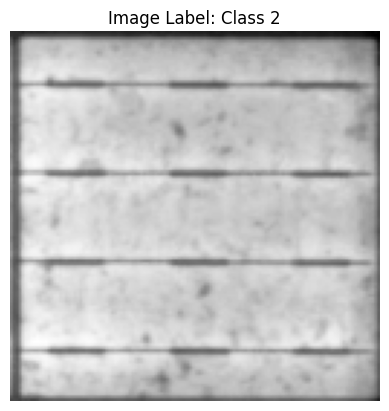

In [5]:
test_image = rearrange(images[0], "c w h -> w h c").numpy()
plt.imshow(test_image, cmap = 'Greys_r')
plt.axis('off')
plt.title(f"Image Label: Class {labels[0]}");

That looks good. We can start by defining our model:
- The `model` object, from `class VAE` in `pytorch_vae.py`
- Our optimizer, which is the defacto standard of `Adam`
- Our criteron/loss function, which we've defined in `pytorch_vae.py` as the sum of a binary crossentropy reconstructive loss and a KL Divergence term for the Gaussian noise.
- We then send our model to the GPU with `model.to(device)`

In [4]:
from pytorch_vae import VAE, VAE_loss
epochs = 20
latent_dim = 2
model = VAE(latent_dim, device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
criterion = VAE_loss

model = model.to(device)

We're now ready to train! We give the model the entire dataset for `epoch`s, and give it batches of images to compute the loss on, which then updates the weights of the network via gradient descent and backpropagation.

In [5]:
losses = []
for epoch in tqdm(range(epochs), total = epochs):
    model.train()
    for batch in dataloader_train:
        X, class_x = batch
        X = X.to(device)
        optimizer.zero_grad()
        recon_X, mu, logvar, z = model.forward(X)
        loss, recon, kld = criterion(recon_X, X, mu, logvar)
        losses.append(loss.detach().item())
        loss.backward()
        optimizer.step()


100%|██████████| 20/20 [00:59<00:00,  2.95s/it]


In [136]:
loss, recon, kld = criterion(recon_X, X, mu, logvar)
recon, kld

(tensor(195735.8438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(105.1077, device='cuda:0', grad_fn=<MulBackward0>))

Let's plot our curve to see if our model learned.

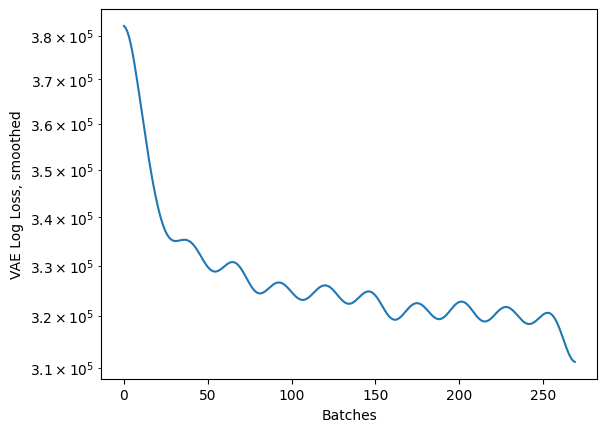

In [204]:
from scipy.ndimage import gaussian_filter1d

plt.plot(gaussian_filter1d(losses,8))
plt.xlabel("Batches")
plt.ylabel("VAE Log Loss, smoothed")
plt.yscale('log') 

This loss curve isn't great-- we need to refine it a bit in production, but it'll do for a demo. 

Let's take a look at the reconstructed images:

Text(0.5, 1.0, 'VAE Reconstructed image')

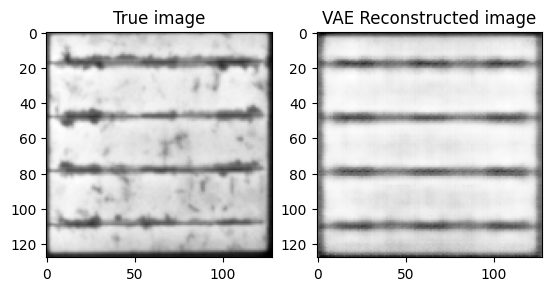

In [46]:
model.eval()
images, labels = next(iter(dataloader_test))
test_image = rearrange(images[0], "c w h -> w h c").numpy()
images = images.to(device)
recon_X_test, _, _, z = model.forward(images)
test_pred = recon_X_test.detach().squeeze().to('cpu').numpy()[0]

fig, axes = plt.subplots(1,2)

axes[0].imshow(test_image, cmap = 'Greys_r')
axes[0].set_title("True image")

axes[1].imshow(test_pred, cmap = 'Greys_r')
axes[1].set_title("VAE Reconstructed image")

Interestingly, our model does not appear to have learned cell types: it correctly reconstructed a image where the cell is "Good" (without any defects), but the input cell is polycrystalline and the output is monocrystalline! This is fine for our purpose, as what we're really interested in is if a cell is good or defective, not what material it's made out of. 

Speaking of prediction, let's grab the feature vectors and inspect them.

In [64]:
feature_vectors = z.detach().cpu().numpy()
feature_vectors.shape

(32, 2)

Text(0.5, 1.0, 'Images projected as points into the VAE feature space')

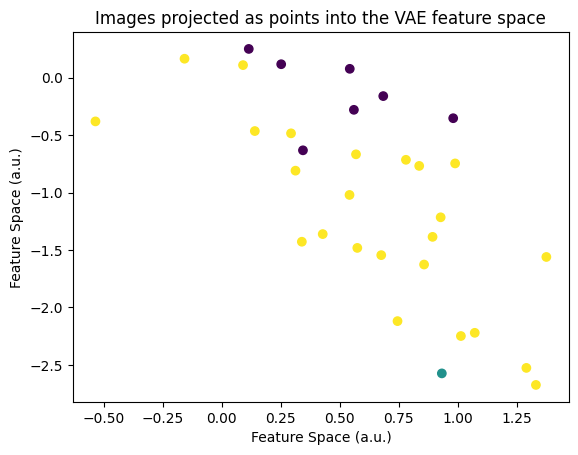

In [65]:
plt.scatter(*feature_vectors.T, c = labels.numpy())
plt.xlabel("Feature Space (a.u.)")
plt.ylabel("Feature Space (a.u.)")
plt.title("Images projected as points into the VAE feature space")
#plt.axis('off');

In this scatter plot, the axes are arbitrary 2D feature space induced by $t$-SNE, and the color corresponds to the real-world classification of the cell (good or corroded, in this case).

It seems that we have two distinct clusters, which means that our model appears to be working for the purpose we intend.


Let's evaluate how well our model did over the entire dataset. We'll increase our `latent_dim` to 80 so that performance is better.

In [35]:
from pytorch_vae import VAE, VAE_loss
epochs = 20
latent_dim = 80
model = VAE(latent_dim, device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
criterion = VAE_loss

model = model.to(device)


losses = []
for epoch in tqdm(range(epochs), total = epochs):
    model.train()
    for batch in dataloader_train:
        X, class_x = batch
        X = X.to(device)
        optimizer.zero_grad()
        recon_X, mu, logvar, z = model.forward(X)
        loss, recon, kld = criterion(recon_X, X, mu, logvar)
        losses.append(loss.detach().item())
        loss.backward()
        optimizer.step()


100%|██████████| 20/20 [01:00<00:00,  3.04s/it]


Now let's have the model predict for all the samples

In [36]:
dataloader_train_all = DataLoader(dataset_train, batch_size=32, shuffle=False)
dataloader_test_all = DataLoader(dataset_test, batch_size=32, shuffle=False)

feature_vectors_all = []
labels_all = []
for ds in [dataloader_train_all, dataloader_test_all]:
    for batch in ds:
        images, labels = batch
        if len(images) != 32:
            continue
        images = images.to(device)
        recon_X_test, _, _, z = model.forward(images)
        feature_vectors = z.detach().cpu().numpy()
        feature_vectors_all.append(feature_vectors)
        labels_all.append(labels.numpy())

feature_vectors_all = np.array(feature_vectors_all)
labels_all = np.array(labels_all)
feature_vectors_all = rearrange(feature_vectors_all, 's b l -> (s b) l')
labels_all = rearrange(labels_all, 's b -> (s b)')

This time, since the dimension of the latent space is higher, we can't directly visualize it. We'll use t-SNE, another non-linear dimensionality reduction technique, to take a look:

In [39]:
features_embedded = TSNE(n_components=2, learning_rate='auto',
                    init='random', perplexity=3).fit_transform(feature_vectors_all)
features_embedded.shape

(992, 2)

Text(0.5, 1.0, 'Images projected as points into the VAE feature space')

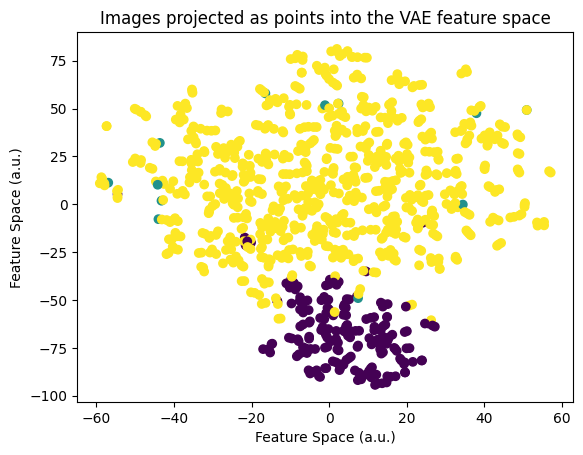

In [40]:
plt.scatter(*features_embedded.T, c = labels_all)
plt.xlabel("Feature Space (a.u.)")
plt.ylabel("Feature Space (a.u.)")
plt.title("Images projected as points into the VAE feature space")
#plt.axis('off');

This embedding looks quite sensible. There is a large cluster for "Good" cells, a smaller cluster for "Corroded" cells, and the "Cracked" cells are intermixed, since they are not very visually different from the "Good cells"

Let's cluster and evaluate accuracy

In [110]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters = 3).fit(feature_vectors_all)
labels_pred = clustering.labels_

In [111]:
from sklearn.metrics import accuracy_score
accuracy_score(labels_all, labels_pred)

0.4586693548387097

This seems low. Let's look at our labels:

In [112]:
labels_all[:300], labels_pred[:300]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

There's a mismatch in labels: What the clustering algorithum calls "Cluster 0" is actually called "Cluster 1" (Corroded) by our labels, and so on for the other classes. Since these numbers are arbitrary, we can swap them around. Note that this is a judgement call: you either label the _samples_ or the _clusters_. 

In [122]:
new_labels = np.full_like(labels_pred, -1)
new_labels[np.where(labels_pred == 0)] = 1
new_labels[np.where(labels_pred == 2)] = 2
new_labels[np.where(labels_pred == 1)] = 0

accuracy_score(labels_all, new_labels)

0.6431451612903226

This still seems low! Why? Let's plot it:

Text(0.5, 1.0, 'Images projected as points into the VAE feature space')

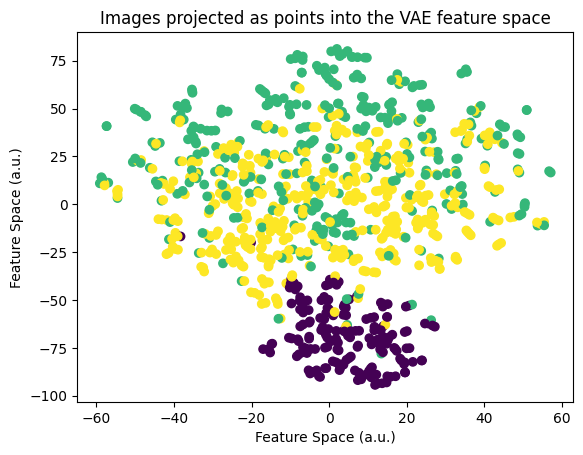

In [121]:
plt.scatter(*features_embedded.T, c = new_labels)
plt.xlabel("Feature Space (a.u.)")
plt.ylabel("Feature Space (a.u.)")
plt.title("Images projected as points into the VAE feature space")
#plt.axis('off');

It appears that in the higher dimensional space, the model has gotten jumbled. One possible mistake is that we mandated that there be three clusters, but if we look at our embeddings, there's really only two classes that are well delineated. 

Let's just assume there's two classes, and furthermore, let's assume that "Cracked" cells are the same as "Good" for this method

In [144]:
clustering = AgglomerativeClustering(n_clusters = 2).fit(feature_vectors_all)
labels_pred = clustering.labels_


new_labels = np.zeros_like(labels_all)
new_labels[np.where(labels_all == 0)] = 1
new_labels[np.where(labels_all == 2)] = 0
new_labels[np.where(labels_all == 1)] = 0

accuracy_score(new_labels, labels_pred)

0.9838709677419355

This is much higher score. Let's see how it does. 

Text(0.5, 1.0, 'Images projected as points into the VAE feature space')

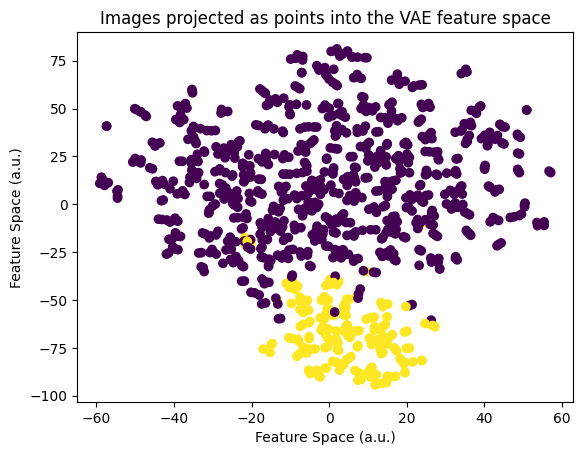

In [145]:
plt.scatter(*features_embedded.T, c = new_labels)
plt.xlabel("Feature Space (a.u.)")
plt.ylabel("Feature Space (a.u.)")
plt.title("Images projected as points into the VAE feature space")
#plt.axis('off');

Here, the clustering appears to be much more sensible. A few notes on what's happened here:

1. Accuracy metrics alone tell you little.
2. When doing unsupervised ML, directly comparing to supervised in terms of metrics isn't exactly apples-to-apples
3. Sample labels and cluster labels are subjective!
4. Unbalanced class problems are a big issue-- model still doesn't really identify cracked cells well (although it gets one right)


Despite these issues, hopefully this demo has shown how we can use unsupervised learning for EL fault detection, and how it both is and is not comparable to supervised learning. 